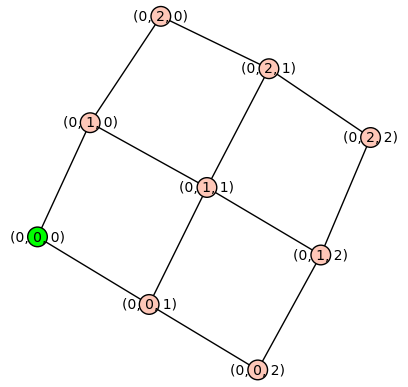

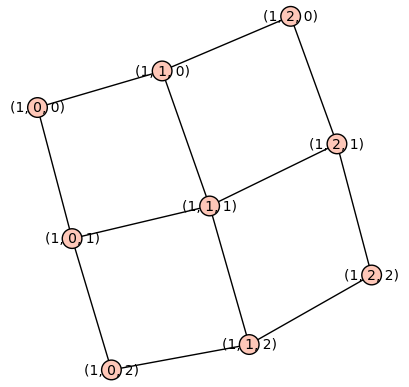

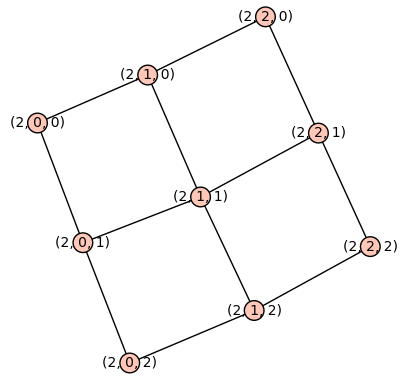

In [87]:
from collections import defaultdict, Counter
from itertools import *

def create_game_graph(num_of_players, num_of_strategies):
    #The gamegraph is isomorphic to hamming graph H(p,q) where 
    #p == num_of_players
    #q == num_of_strategies
    G = graphs.HammingGraph(num_of_players, num_of_strategies)
    all_vars = []
    vertex_to_index = {}
    #Set variables for each vertex
    #ex, in the 3x3 game graph case, the first vertex has the variables
    #v_0_0, v_0_1, v_0_2
    for i, vertex in enumerate(G.vertices()):
        vertex_to_index[vertex]=i
        vars = [var('v_{0}_{1}'.format(i,j)) for j,_ in enumerate(vertex)]
        for v in vars:
    #        assume(v,'integer')
            all_vars.append(v)
            G.set_vertex(vertex, vars)

    #Set edge labels for the deltas
    #ex. The edge between vertex 0,0,0 and vertex 0,0,1, adjacent along variable 2 
    #will have the label (2, d_0_0_0_0_0_1)
    vertex_to_deltas=defaultdict(list)
    for i, edge in enumerate(G.edges()):
        u,v,_ = edge
        coord  = 0
        for j, (x,y) in enumerate(zip(u, v)):
            if x==y:
                #this is the coordinate we are adjacent on
                coord = j
        delta = var("d_{0}_{1}".format('_'.join(map(str,u)),'_'.join(map(str,v))))
        #Any delta we actually use in an equation will be non-negative
        assume(delta>0)
              #      all_vars.append(delta)
        G.set_edge_label(u,v, (coord, delta))

    return (G, all_vars)
        
def create_zero_sum_equations(G, include_matrix_rows = False):
    zero_sums = []
    matrix_rows = []
    #Each vertex is zero sum
    vertices = list(G.vertices())
    length = len(vertices)*len(vertices[0]) +1
    for i, vertex in enumerate(G.vertices()):
        vars = G.get_vertex(vertex)
        qe = reduce(lambda x,y:x+y, vars)
        zero_sums.append(qe==0)   
        
        row = [0 for _ in range(length)]
        index = i*3
        row[index] = 1
        row[index+1] = 1
        row[index+2] = 1
        matrix_rows.append(row)
        
    if include_matrix_rows:
        return (zero_sums, matrix_rows)
    return zero_sums


def create_delta_equations(G, configuration, include_matrix_rows = False):
    deltas = []
    vertex_to_deltas = {}
    
    vertices = list(G.vertices())
    length = len(vertices)*len(vertices[0]) +1
    matrix_rows = []
    
    vertex_to_index = {}
    for i, v in enumerate(vertices):
        vertex_to_index[v] = i
    tuple_size = len(vertices[0])
    #Each edge's delta is equal to the difference of its matching vertex elements
    for i, edge in enumerate(G.edges()):
        u,v, (coord, delta) = edge
        u_is_nash = u in configuration
        v_is_nash = v in configuration
        if not u_is_nash and not v_is_nash:
            #Two non-nashes can have any difference, doesn't matter
            continue
            
        #get the variables that are specifically adjacent for the two
        #vertices
        u_var = G.get_vertex(u)[coord]
        v_var = G.get_vertex(v)[coord]
        u_var_coord = vertex_to_index[u]*tuple_size+coord
        v_var_coord = vertex_to_index[v]*tuple_size+coord
        row = [0 for _ in range(length)]
        #If both are nash, we set the equation to 0
        #If only one is nash, we set the equation to = the edge delta
        if u_is_nash:
            if not v_is_nash:
                difference = u_var - v_var == delta
                row[u_var_coord] = 1
                row[v_var_coord] = -1
                row[-1] = delta
            else:
                difference = u_var - v_var == 0
                row[u_var_coord] = 1
                row[v_var_coord] = -1
                
        else:
                difference = v_var - u_var == delta
                row[u_var_coord] = -1
                row[v_var_coord] = 1
                row[-1] = delta

        matrix_rows.append(row)
        deltas.append(difference)
        
    if include_matrix_rows:
        return (deltas, matrix_rows)
    return deltas

def is_feasible(G, all_vars, configuration):
    zero_sums = create_zero_sum_equations(G)
    deltas = create_delta_equations(G, configuration)
    solutions = solve(zero_sums + deltas, *all_vars)
    return solutions is not None and len(solutions) > 0

def test_feasible1():
    G, vars = create_game_graph(3,3)
    #One vertex as nash and all other non-nash is feasible
    configuration = [list(G.vertices())[0]]
    print(is_feasible(G, vars, configuration))

def test_feasible2():
    G, vars = create_game_graph(3,3)
    #All but one vertex being nash is infeasible
    configuration = list(G.vertices())[0:25]
    print(is_feasible(G, vars, configuration))
    
def show_with_config(G, configuration):
    vertex_colors = defaultdict(list)
    for v in G.vertices():
        if v in configuration:
            vertex_colors["#00FF00"].append(v)
    G.show(vertex_colors = vertex_colors)
    
def display_3x3_game_graph(G, configuration):
    ##Display a 3 player 3 strategy game 
    ##It is broken into three layers to make it easier to visualize
    
    
    #to make things neater, let's only draw the edges for 
    #vertices with distance 1
    simple_edges = []
    for edge in G.edges():
        u, v, (coord, label) =edge
        dist = sum(abs(u_c - v_c) for u_c, v_c in zip(u,v))
        
        if dist==1:
            simple_edges.append( edge)
            
    top_layer = G.subgraph(vertices = list(G.vertices())[0:9], edges = simple_edges)
    show_with_config(top_layer, configuration)
    mid_layer = G.subgraph(vertices = list(G.vertices())[9:18], edges=simple_edges)
    show_with_config(mid_layer, configuration)
    bot_layer = G.subgraph(vertices = list(G.vertices())[18:], edges = simple_edges)
    show_with_config(bot_layer, configuration)
    
def test_display_game_graph():
    G, vars = create_game_graph(3,3)
    configuration = [list(G.vertices())[0]]
    display_3x3_game_graph(G, configuration)
 
test_display_game_graph()


In [1]:
#Algorithm Helpers

    

def convert_eqs_to_solvable_form(G, qes):
    deltas = []
    for u,v,(coord, delta) in G.edges():
        deltas.append(delta)
        
    #Create a multipolynomial ring for this delta
    R_ = PolynomialRing(QQ,','.join(map(str, deltas)))
    deltas_ = R_.gens()
    convert_map = {}
    for d, d_ in zip(deltas, deltas_):
        convert_map[str(d)] = d_
        

    system = qes  
  #  system = [create_matrix_row(qe, v_index) for qe in qes]
  #  print(system)
    return matrix([[x if str(x) not in convert_map else convert_map[str(x)] for x in qe] for qe in system])
    
def test_conversion():
    G, all_vars = create_game_graph(3,3)
    zero_sums, zero_sum_matrix = create_zero_sum_equations(G, True)
    configuration = [list(G.vertices())[0]]
    deltas, deltas_matrix = create_delta_equations(G, configuration, True)
    eqs = zero_sum_matrix + deltas_matrix
    eqs_ = convert_eqs_to_solvable_form(G, eqs)
    print(matrix(eqs_))

test_conversion()

def get_deltas(qe):
    #Returns from equation the deltas in a map
    #all positive deltas are mapped to '+'
    #all negative deltas are mapped to '-'
    vars = qe.variables()
    m = defaultdict(list)
    for v in vars:
        coefficient = qe.coefficient(v)
        if coefficient > 0:
            m['+'].append(v)
        else:
            m['-'].append(v)
    return m


def has_delta(x, delta):
    #Returns '+' if delta is present in equation x's positive deltas
    #Returns '-' if delta is present in equation x's negative deltas
    #Returns False is it is not present.
    deltas = get_deltas(x)
    if delta in deltas['+']: return '+'
    if delta in deltas['-']: return '-'
    return False

def make_pos(x, delta):
    #Returns a copy of x such that delta is positive
    deltas = get_deltas(x)
    if delta in deltas['-']: return -x
    return x

def algorithm(eqs):
    #In Progress
    eqs_ = list(eqs)
    partitions = []
    while len(eqs_)>0:
        #Select an equation
        rep = eqs_[0]
        rep_deltas = get_deltas(rep)
        #Select a positive delta d_z
        d_z = rep_deltas['+'][0]
        #Find those with that d_z
        partition = [x for x in eqs_ if has_delta(x, d_z)]
        #Make sure d_z is positive for everyone
        partition_ = [make_pos(x,d_z) for x in eqs_]
        partitions.append((d_z, partition_))
        eqs_ = [x for x in eqs_ if x not in partition]
    eliminated = set()

    for p, partition in enumerate(partitions):
        deleted = []

        while i < len(partition[i]):
            eq = partition[i]
            #select a negative d
            rep_deltas = get_deltas(eq)
            d_pumps = [d for d in get_deltas(eq)['-'] if d not in deleted]
            if len(d_pumps)==0:
                print("RESTART")
                ###
            #TODO replace with selecting a different delta in the event this was a bad choice
            d_pump = d_pumps[0]
            #is this in someone else's negatives? We should return and try a different delta
            for j, eq2 in enumerate(partition[0:i]):
                if has_delta(eq, d_pump)=='-':
                    print("Go back up")
                    partition[i],partition[j] = eq2, eq
                    i = j
                    deleted = deleted[0:i]
                    break
            else:
                i+=1
    print("DONE")

NameError: name 'create_game_graph' is not defined